In [33]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay
from casadi import *

from utils import get_trajectory, get_position, get_casadi_interpolation

In [34]:
# Hyperparameters
test_results = True
T = 15 # Time horizon
N = 20 # Number of control intervals BEST UNTIL NOW: 25

In [35]:
plt.rcParams['figure.figsize'] = [7, 7]

In [36]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [37]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

In [38]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.28], 0]

/home/giulio/prog/duckrace_simulator/utils.py:238: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


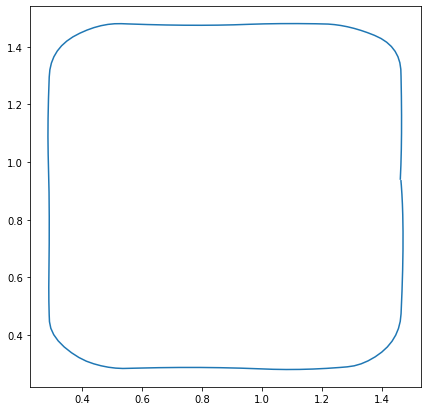

In [39]:
env.reset()
traj = get_trajectory(env, samples=200)
plt.plot(*traj.T)

In [40]:
pose = get_position(env)
pose

Position(x=0.7019999027252197, y=1.4749999999999999, theta=0)

/home/giulio/prog/duckrace_simulator/utils.py:238: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


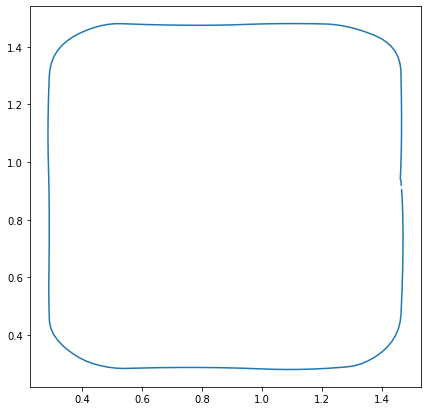

In [41]:
spline_x, spline_y, _, _, x_origin, y_origin = get_casadi_interpolation(env, show_result=True)

Initialize states, inputs, and system dynamic equation

In [42]:
dt = 1.0 / env.frame_rate

In [43]:
u1 = 5
w1 = 4
# parameters for forced dynamics
u_alpha_r = 1.5
u_alpha_l = 1.5
w_alpha_r = 15  # modify this for trim
w_alpha_l = 15

In [44]:
# # States
# x0 = MX.sym('x')
# y0 = MX.sym('y')
# th0 = MX.sym('th')
# v0 = MX.sym('v')
# w0 = MX.sym('w')
# x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# # Inputs
# wl = MX.sym('wl')
# wr = MX.sym('wr')
# u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# # System dynamics (CAN BE NONLINEAR! ;))
# x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
# w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
# x_dot_dot = x_long_dot_dot*cos(th0)
# y_dot_dot = x_long_dot_dot*sin(th0)
# ode = vertcat(x_long_dot_dot, w_dot_dot, x_dot_dot, y_dot_dot) # ORDINARY DIFFERENTIAL EQUATION: Always vertically concatenate dynamic equations --> [n_x,1]
# f = Function('f',[x,u],[ode],['x','u'],['ode'])
# if test_results:
#     print(f([0.702, 1.344706, 0, 0, 0], [1, 1]))

In [45]:
pose = get_position(env)

Directly dae?

In [46]:
# States
x0 = MX.sym('x')
y0 = MX.sym('y')
th0 = MX.sym('th')
v0 = MX.sym('v')
w0 = MX.sym('w')
x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# Inputs
wl = MX.sym('wl')
wr = MX.sym('wr')
u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
v1 = v0 + x_long_dot_dot*dt
w1 = w0 + w_dot_dot*dt
x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
theta1 = th0 + w0*dt
dae = vertcat(x1, y1, theta1, v1, w1)
F = Function('F',[x,u],[dae],['x','u'],['dae'])
if test_results:
    print(F([pose.x, pose.y, pose.theta, 0, 0], [1, 1]))

[0.70199990272522, 1.475, 0, 0.1, 0]


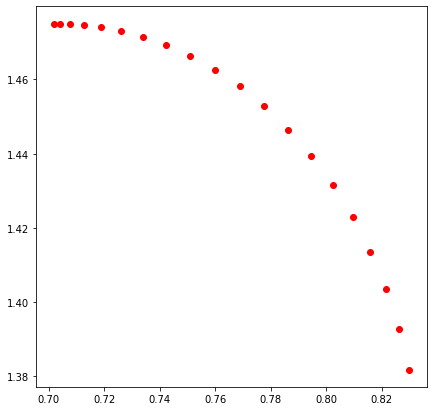

In [47]:
# Test the problem definition
sim = F.mapaccum(N) # To call the F function N times
x0 = [pose.x, pose.y, pose.theta, 0, 0]
res = sim(x0, [1, 0.2])
fig = plt.figure()
tgrid = np.linspace(0,T,N+1)
# plt.plot(tgrid, np.column_stack((x0, res)).T)
plt.plot(res[0, :], res[1, :], 'ro')

In [48]:
from scipy.sparse import csc_matrix
U = MX.sym('U', 2, N)
X1 = sim(x0,U)[0,:]
J = jacobian(X1,U)

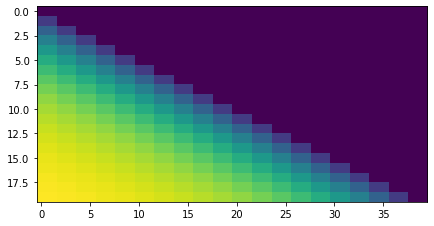

In [49]:
Jf = Function('Jf',[U],[J])
plt.imshow(Jf(0))

In [50]:
def mpc_loss(x):
    """
    L(u) = sum_{t=0}^{N-1} Q * ||x_o_t - x_t||^2 + R * ||u_t||^2
    """
    loss = 0
    for t in range(0, N):
        xi, yi = x[0, t], x[1, t]
        r = sqrt((xi-x_origin)**2 + (yi-y_origin)**2)
        angle = arccos((xi-x_origin)/r)
        angle = if_else(yi-y_origin < 0, 2*pi-angle, angle)
        x_ref, y_ref = spline_x(angle), spline_y(angle)
        loss += ((xi - x_ref)**2 + (yi - y_ref)**2)

    return loss


In [51]:
def u_close_to_1(u):
    return sumsqr(1-u)

In [52]:
opti = Opti() # Special CasADi stack for optimization

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
p = opti.parameter(5,1)     # Parameter to set the initial state conditions (x(0))

Q, R = 3.4, 0.33 # BEST UNTIL NOW 3.4, 0.33
obj = Q*mpc_loss(x) + R*u_close_to_1(u)   # Objective function: (NOT NECESSARILY quadratic!)

opti.minimize(obj)          # Setup the problem 

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
   opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k])) # System dynamics is called through F, that we defined above as the DAE that maps (x,u) --> (x,next)
    
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u)<=1)
opti.subject_to(vec(u)>=-1)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0]==p)

opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value

# Set additional options
opts = dict()
opts["qpsol"] = "qrqp" # Solver! See the docs for information
opts["print_header"] = False
opts["print_iteration"] = False
opts["print_time"] = False
opts["qpsol_options"] = dict({"print_iter":False,"print_header":False,"print_info":False,"error_on_fail":False})
opti.solver("sqpmethod", opts)

# If you want to test over 1 time horizon
if test_results:
    sol = opti.solve() # For testing purpose: test the optimization on 1 time step
    fig = plt.figure
    plt.plot(tgrid, sol.value(x[0,:]).T, label='x')
    plt.plot(tgrid, sol.value(x[1,:]).T, label='y')
    plt.plot(tgrid, np.column_stack((sol.value(u)[0].reshape(1,-1), np.NaN)).T, drawstyle='steps-post', label='wl')
    plt.plot(tgrid, np.column_stack((sol.value(u)[1].reshape(1,-1), np.NaN)).T, drawstyle='steps-post', label='wr')
    plt.grid(True)
    plt.legend()

WARNING(sqpmethod): Indefinite Hessian detected
MESSAGE(sqpmethod): Search direction becomes too small without convergence criteria being met.


RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Search_Direction_Becomes_Too_Small'

Final Step: run the MPC control loop!
N.B. Given that we want to simulate the system, e.g., 50 timesteps,
1. at each time step the previosly defined optimization problem computes inputs u and predicted states x in the prediction horizon N.
2. from computed sequence of inputs (u(0), ..., u(T)), ONLY u(0) value is selected to simulate the system
3. (x0, u(0)) --> x_next == x(1)
4. the loop restart

In [ ]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[p],[u[:,0]],['p'],['u_opt'])

In [ ]:
# MPC loop
X_log = np.empty((5,0))
U_log = np.array([])

x = [pose.x, pose.y, pose.theta, 0, 0]
for i in range(400):
    u = M(x)

    U_log = np.append(U_log, u)
    X_log = np.column_stack((X_log, x))

    # simulate
    x = F(x,u)

MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
MESSAGE(sqpmethod): Convergence achieved

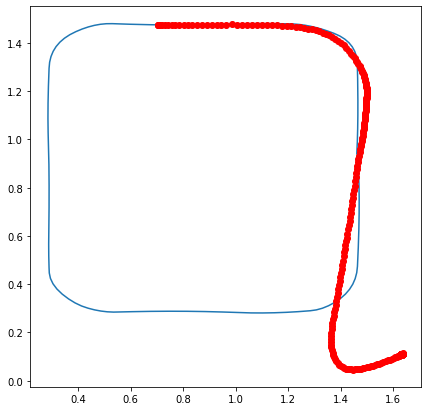

In [ ]:
plt.plot(*traj.T)
plt.plot(X_log[0,:], X_log[1,:], 'ro')

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [ ]:
M.save('M.casadi')
M2 = Function.load('M.casadi')
DM.set_precision(15)
print(M(x0))
print(M2(x0))

MESSAGE(sqpmethod): Convergence achieved after 7 iterations
[0.99480761667963, 1]
MESSAGE(sqpmethod): Convergence achieved after 7 iterations
[0.99480761667963, 1]
